In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tf2cv tensorflow>=2.0.0

In [0]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7348605730312740593
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [0]:
#global consts
IMG_SIZE='137x236'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=128
DROP_OUT=0.0
FOLD=0
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_128 = (0.0692, 0.2051)
EXPERIMENT='sernext_augmix'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
DATASET_224='224x224-bengali.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
TRAIN_WITH_FOLD = 'train_with_fold_20.csv'
PRETRAINED = False
PRETRAINED_WEIGHTS = ''
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == 224: DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [0]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
#from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Progbar
from sklearn.utils import class_weight

In [0]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)

/content/drive/My Drive/kaggle/bengali/output/sernext_augmix/ already exists
/content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ already exists


0

In [0]:
if PRETRAINED: os.system('cp '+ '"'+OUTPUT_DIR+OUTPUT_SUBDIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [0]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [0]:
!ls train

137x236  bengali-full-size.zip	train_with_fold_20.csv


In [0]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD).to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
cons_unique=np.unique(train_np[:,3])
cons_y_train = train_np[:,3]
vowel_unique=np.unique(train_np[:,2])
vowel_y_train = train_np[:,2]
root_unique =np.unique(train_np[:,1])
root_y_train = train_np[:,1]

cons_class_weights = class_weight.compute_class_weight('balanced',
                                                 cons_unique,
                                                 cons_y_train)

vowel_class_weights = class_weight.compute_class_weight('balanced',
                                                 vowel_unique,
                                                 vowel_y_train)

root_class_weights = class_weight.compute_class_weight('balanced',
                                                 root_unique,
                                                 root_y_train)
cons_cw_dict=dict(enumerate(cons_class_weights))
vowel_cw_dict=dict(enumerate(vowel_class_weights))
root_cw_dict=dict(enumerate(root_class_weights))

model_cw={}
model_cw['root']=root_cw_dict
model_cw['vowel']=vowel_cw_dict
model_cw['consonant']=cons_cw_dict

In [0]:
model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)

In [0]:
if 0: model.summary()

In [0]:
if 0:
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file=OUTPUT_DIR+'model3.png',show_shapes=True)

In [0]:
if 0:
  for (n, layer) in enumerate(model.layers[1].layers):
    if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
      print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
      layer.activation = Mish(mish)
      print('-> {}'.format(layer.activation))

In [0]:
TRAIN_DIR+PRETRAINED_WEIGHTS

'./train/'

In [0]:
if 0: 
  model.load_weights(TRAIN_DIR+PRETRAINED_WEIGHTS)
  valid_gen = test_batch_generator(valid_df,TRAIN_IMG_DIR,batch_size=512)
  root_predicts,vowel_predicts,cons_predicts=get_p_dicts(model,valid_gen)
  root_recalls,_,_ = compute_cm(valid_df,root_predicts,vowel_predicts,cons_predicts)
  root_weights = 1./np.power(root_recalls,2)
else:
  root_weights = 1.0


In [0]:
if 0: root_weights[62]

In [0]:
cutout_datagen = ImageDataGenerator(rotation_range = 15,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function=get_random_eraser(s_l=0.05,s_h=0.1,r_1=0.8,r_2=1.2,v_l=0,v_h=0))

mcm_datagen = ImageDataGenerator()

In [0]:
columns=["root_class","vowel_class", "cons_class"]

mcm_generator1 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

mcm_generator2 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")


cutout_generator = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

Found 190798 validated image filenames.
Found 190798 validated image filenames.
Found 190798 validated image filenames.


In [0]:
def cutout_batch_fs(batch, p=0.5, s_l=0.05,s_h=0.3,r_1=0.2,r_2=5.0, st=STATS_FS):
        x,y = prep_batch_fs(batch,st=st)
        p_1 = np.random.rand()

        if p_1 > p:
            return x,y

        bs,img_h, img_w, img_c = x.shape

        for i in range(bs):
          while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

          x[i,top:top + h, left:left + w, :] = 0

        return x,y

In [0]:
def ps_batch_fs(batch, n=4, p=0.5, s_l=0.05,s_h=0.15,r_1=0.8,r_2=1.2, st=STATS_FS):
        x,y = prep_batch_fs(batch,st=st)
        p_1 = np.random.rand()

        if p_1 > p:
            return x,y

        bs,img_h, img_w, img_c = x.shape

        for i in range(bs):
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / n*r))
            h = int(np.sqrt(s * r/n))
            left = np.random.randint(0, img_w-w-1,size=n)
            top =  np.random.randint(0, img_h-h-1,size=n)
            for j in range(n):
              x[i,top[j]:top[j] + h, left[j]:left[j] + w, :] = 0

        return x,y

In [0]:
#cutout+progressive+mixup
def cpsm_generator_fs(gen1,gen2, gen3,st=STATS_FS):
    while True:
        p = np.random.rand()
        #print(f'p={p}')
        if p>0.5:
            batch = next(gen3)
            q  = np.random.rand()
            #print(f'q={q}')
            if q>0.5:
              #print('cutout')
              x_res,y_res = cutout_batch_fs(batch,st=st)
            else:
              #print('ps')
              ps_n = np.random.randint(4,16)
              x_res,y_res = ps_batch_fs(batch,n=ps_n)
        else:
            #print('mixup')
            batch1 = next(gen1)
            batch2 = next(gen2)
            mx_alpha = np.random.uniform(0.1,0.4)
            x_res,y_res = mix_batches_fs(batch1,batch2,alpha=mx_alpha,st=st)

        yield x_res,y_res

In [0]:
#reference https://drive.google.com/drive/folders/1oYYeg4SCvpyyOG9ReERypHy_Z9LFPl-u
def do_identity(image, magnitude=None):
    return image


# *** geometric ***

def do_random_projective(image, magnitude=0.5):
    mag = np.random.uniform(-1, 1) * 0.5*magnitude

    height, width = image.shape[:2]
    x0,y0=0,0
    x1,y1=1,0
    x2,y2=1,1
    x3,y3=0,1

    mode = np.random.choice(['top','bottom','left','right'])
    if mode =='top':
        x0 += mag;   x1 -= mag
    if mode =='bottom':
        x3 += mag;   x2 -= mag
    if mode =='left':
        y0 += mag;   y3 -= mag
    if mode =='right':
        y1 += mag;   y2 -= mag

    s = np.array([[ 0, 0],[ 1, 0],[ 1, 1],[ 0, 1],])*[[width, height]]
    d = np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3],])*[[width, height]]
    transform = cv2.getPerspectiveTransform(s.astype(np.float32),d.astype(np.float32))

    image = cv2.warpPerspective( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image


def do_random_perspective(image, magnitude=0.5):
    mag = np.random.uniform(-1, 1, (4,2)) * 0.25*magnitude

    height, width = image.shape[:2]
    s = np.array([[ 0, 0],[ 1, 0],[ 1, 1],[ 0, 1],])
    d = s+mag
    s *= [[width, height]]
    d *= [[width, height]]
    transform = cv2.getPerspectiveTransform(s.astype(np.float32),d.astype(np.float32))

    image = cv2.warpPerspective( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image


def do_random_scale( image, magnitude=0.5 ):
    s = 1+np.random.uniform(-1, 1)*magnitude*0.5

    height, width = image.shape[:2]
    transform = np.array([
        [s,0,0],
        [0,s,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image



def do_random_shear_x( image, magnitude=0.5 ):
    sx = np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1,sx,0],
        [0,1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_shear_y( image, magnitude=0.5 ):
    sy = np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1, 0,0],
        [sy,1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_stretch_x(image, magnitude=0.5 ):
    sx = 1+np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [sx,0,0],
        [0, 1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_stretch_y(image, magnitude=0.5 ):
    sy = 1+np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1, 0,0],
        [0,sy,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_rotate(image, magnitude=0.5 ):
    angle = 1+np.random.uniform(-1, 1)*30*magnitude

    height, width = image.shape[:2]
    cx, cy = width // 2, height // 2

    transform = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


#----
def do_random_grid_distortion(image, magnitude=0.5 ):
    num_step = 5
    distort  = magnitude

    # http://pythology.blogspot.sg/2014/03/interpolation-on-regular-distorted-grid.html
    distort_x = [1 + np.random.uniform(-distort,distort) for i in range(num_step + 1)]
    distort_y = [1 + np.random.uniform(-distort,distort) for i in range(num_step + 1)]

    #---
    height, width = image.shape[:2]
    xx = np.zeros(width, np.float32)
    step_x = width // num_step

    prev = 0
    for i, x in enumerate(range(0, width, step_x)):
        start = x
        end   = x + step_x
        if end > width:
            end = width
            cur = width
        else:
            cur = prev + step_x * distort_x[i]

        xx[start:end] = np.linspace(prev, cur, end - start)
        prev = cur

    yy = np.zeros(height, np.float32)
    step_y = height // num_step
    prev = 0
    for idx, y in enumerate(range(0, height, step_y)):
        start = y
        end = y + step_y
        if end > height:
            end = height
            cur = height
        else:
            cur = prev + step_y * distort_y[idx]

        yy[start:end] = np.linspace(prev, cur, end - start)
        prev = cur

    map_x, map_y = np.meshgrid(xx, yy)
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image

#https://github.com/albumentations-team/albumentations/blob/8b58a3dbd2f35558b3790a1dbff6b42b98e89ea5/albumentations/augmentations/transforms.py

# https://ciechanow.ski/mesh-transforms/
# https://stackoverflow.com/questions/53907633/how-to-warp-an-image-using-deformed-mesh
# http://pythology.blogspot.sg/2014/03/interpolation-on-regular-distorted-grid.html
def do_random_custom_distortion1(image, magnitude=0.5):
    distort=magnitude*0.3

    height,width = image.shape[:2]
    s_x = np.array([0.0, 0.5, 1.0,  0.0, 0.5, 1.0,  0.0, 0.5, 1.0])
    s_y = np.array([0.0, 0.0, 0.0,  0.5, 0.5, 0.5,  1.0, 1.0, 1.0])
    d_x = s_x.copy()
    d_y = s_y.copy()
    d_x[[1,4,7]] += np.random.uniform(-distort,distort, 3)
    d_y[[3,4,5]] += np.random.uniform(-distort,distort, 3)

    s_x = (s_x*width )
    s_y = (s_y*height)
    d_x = (d_x*width )
    d_y = (d_y*height)

    #---
    distort = np.zeros((height,width),np.float32)
    for index in ([4,1,3],[4,1,5],[4,7,3],[4,7,5]):
        point = np.stack([s_x[index],s_y[index]]).T
        qoint = np.stack([d_x[index],d_y[index]]).T

        src  = np.array(point, np.float32)
        dst  = np.array(qoint, np.float32)
        mat  = cv2.getAffineTransform(src, dst)

        point = np.round(point).astype(np.int32)
        x0 = np.min(point[:,0])
        x1 = np.max(point[:,0])
        y0 = np.min(point[:,1])
        y1 = np.max(point[:,1])
        mask = np.zeros((height,width,1),np.float32)
        mask[y0:y1,x0:x1,0] = 1

        mask = mask*image
        warp = cv2.warpAffine(mask, mat, (width, height),borderMode=cv2.BORDER_REPLICATE)
        distort = np.maximum(distort,warp)
        #distort = distort+warp

    return distort


# *** intensity ***
def do_random_contast(image, magnitude=0.5):
    alpha = 1 + np.random.uniform(-1,1)*magnitude
    image = image.astype(np.float32) * alpha
    image = np.clip(image,0,1)
    return image


def do_random_block_fade(image, magnitude=0.5):
    size  = [0.1, magnitude]

    height,width = image.shape[:2]

    #get bounding box
    m = image.copy()
    cv2.rectangle(m,(0,0),(height,width),1,5)
    m = image<0.5
    if m.sum()==0: return image

    m = np.where(m)
    y0,y1,x0,x1 = np.min(m[0]), np.max(m[0]), np.min(m[1]), np.max(m[1])
    w = x1-x0
    h = y1-y0
    if w*h<10: return image

    ew, eh = np.random.uniform(*size,2)
    ew = int(ew*w)
    eh = int(eh*h)

    ex = np.random.randint(0,w-ew)+x0
    ey = np.random.randint(0,h-eh)+y0

    image[ey:ey+eh, ex:ex+ew] *= np.random.uniform(0.1,0.5) #1 #
    image = np.clip(image,0,1)
    return image


# *** noise ***
# https://www.kaggle.com/ren4yu/bengali-morphological-ops-as-image-augmentation
def do_random_erode(image, magnitude=0.5):
    s = int(round(1 + np.random.uniform(0,1)*magnitude*6))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple((s,s)))
    image  = cv2.erode(image, kernel, iterations=1)
    return image

def do_random_dilate(image, magnitude=0.5):
    s = int(round(1 + np.random.uniform(0,1)*magnitude*6))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple((s,s)))
    image  = cv2.dilate(image, kernel, iterations=1)
    return image

def do_random_sprinkle(image, magnitude=0.5):

    size = 16
    num_sprinkle = int(round( 1 + np.random.randint(10)*magnitude ))

    height,width = image.shape[:2]
    image = image.copy()
    image_small = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    m   = np.where(image_small>0.25)
    num = len(m[0])
    if num==0: return image

    s = size//2
    i = np.random.choice(num, num_sprinkle)
    for y,x in zip(m[0][i],m[1][i]):
        y=y*4+2
        x=x*4+2
        image[y-s:y+s, x-s:x+s] = 0 #0.5 #1 #
    return image


#https://stackoverflow.com/questions/14435632/impulse-gaussian-and-salt-and-pepper-noise-with-opencv
def do_random_noise(image, magnitude=0.5):
    height,width = image.shape[:2]
    noise = np.random.uniform(-1,1,(height,width,1))*magnitude*0.7
    image = image+noise
    image = np.clip(image,0,1)
    return image



def do_random_line(image, magnitude=0.5):
    num_lines = int(round(1 + np.random.randint(8)*magnitude))

    # ---
    height,width = image.shape[:2]
    image = image.copy()

    def line0():
        return (0,0),(width-1,0)

    def line1():
        return (0,height-1),(width-1,height-1)

    def line2():
        return (0,0),(0,height-1)

    def line3():
        return (width-1,0),(width-1,height-1)

    def line4():
        x0,x1 = np.random.choice(width,2)
        return (x0,0),(x1,height-1)

    def line5():
        y0,y1 = np.random.choice(height,2)
        return (0,y0),(width-1,y1)

    for i in range(num_lines):
        p = np.array([1/4,1/4,1/4,1/4,1,1])
        func = np.random.choice([line0,line1,line2,line3,line4,line5],p=p/p.sum())
        (x0,y0),(x1,y1) = func()

        color     = np.random.uniform(0,1)
        thickness = np.random.randint(1,5)
        line_type = np.random.choice([cv2.LINE_AA,cv2.LINE_4,cv2.LINE_8])

        cv2.line(image,(x0,y0),(x1,y1), color, thickness, line_type)

    return image


augmentations = [do_random_shear_x, 
                 do_random_shear_y,
                 do_random_sprinkle,
                 do_random_line,
                 do_random_custom_distortion1,
                 do_random_dilate,
                 do_random_rotate,
                 do_random_stretch_y,
                 do_random_stretch_x,
                 do_random_projective,
                 do_random_grid_distortion,
                 do_random_perspective,
                 do_random_erode,
                 do_random_noise,
                 do_random_block_fade,
                 do_random_contast,
                 do_random_scale]

In [0]:
def apply_op(image, op, severity):
    height, width = image.shape[:2]
    return op(image, severity).reshape(height,width,1)

In [0]:
#reference https://github.com/AakashKumarNain/AugMix_TF2/blob/master/data_generator.py
def augment_and_mix(image, severity=0.5, width=3, depth=-1, alpha=1.):
        """Perform AugMix augmentations and compute mixture.
        Args:
            image: Raw input image as ndarray shape (h, w, c)
            severity: Severity of underlying augmentation operators (1-10).
            width: Width of augmentation chain
            depth: Depth of augmentation chain. -1 or (1, 3)
            alpha: Probability coefficient for Beta and Dirichlet distributions.
        Returns:
            mixed: Augmented and mixed image.
        """
        ws = np.random.dirichlet([alpha] * width).astype(np.float32)
        m  = np.float32(np.random.beta(alpha, alpha))
        mix = np.zeros_like(image).astype(np.float32)

        for i in range(width):
            image_aug = image.copy()
            depth = depth if depth > 0 else np.random.randint(1, 4)
            for _ in range(depth):
                op = np.random.choice(augmentations)
                image_aug = apply_op(image_aug, op, severity)
                # Preprocessing commutes since all coefficients are convex
                mix += ws[i] * image_aug

        # mix the image and return 
        mixed = (1 - m)*image + m*mix
        return mixed

In [0]:
#reference https://github.com/AakashKumarNain/AugMix_TF2/blob/master/data_generator.py
def augmix_batch_fs(batch,st=STATS_FS):
  x_orig,y = prep_batch_fs(batch,st=st)
  bs = x_orig.shape[0]

  x_aug1 = np.zeros_like(x_orig, dtype=np.float32)
  #x_aug2 = np.zeros_like(x_orig, dtype=np.float32)

  for i in range(bs):
    x_aug1[i] = augment_and_mix(x_orig[i])
    #x_aug2[i] = augment_and_mix(x_orig[i])

  return  x_aug1, y


In [0]:
def augmix_generator_fs(gen,st=STATS_FS):
  while True:
    batch = next(gen)
    x_aug1,y = augmix_batch_fs(batch,st=st)
    yield x_aug1,y

In [0]:
if 0:
  mixup_datagen=mixup_data_gen(aux_data_gen(mcm_generator1),aux_data_gen(mcm_generator2))
  cutout_datagen=aux_data_gen(cutout_generator)
  h_datagen=hybrid_data_gen(mixup_datagen,cutout_datagen)
  h2_datagen=h_generator(mcm_generator1,mcm_generator2,cutout_generator)
  hmcm_datagen=hmcm_generator(mcm_generator1,mcm_generator2)
  g3_datagen = g3_generator(mcm_generator1,mcm_generator2,cutout_generator)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)
  cpsm_datagen_fs = cpsm_generator_fs(mcm_generator1,mcm_generator2,cutout_generator, st=STATS_FS)

augmix_datagen_fs = augmix_generator_fs(mcm_generator1,st=STATS_FS)

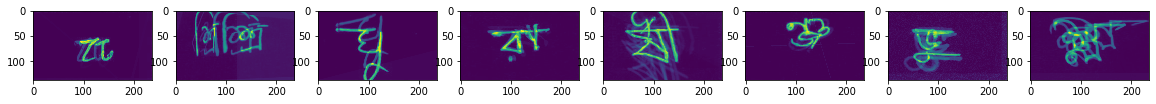

In [0]:
if 1: 
  n=8
  batch_x,y = next(augmix_datagen_fs)
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(1, n, figsize=(20, 5))
  for i in range(n):
    axs[i].imshow(batch_x[i,:,:,0])
  plt.show()

In [0]:
if 0: opt = Lookahead(tf.keras.optimizers.SGD(learning_rate=LR_MAX, momentum=0.9,nesterov=True))

opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)

In [0]:
checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)

In [0]:
chkp_manager.latest_checkpoint

In [0]:
chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
  print("Restored from {}".format(chkp_manager.latest_checkpoint))
  print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
else:
  print("Initializing from scratch.")

Initializing from scratch.


In [0]:
loss_dict={'root':    'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[2.0,1.0,1.0])

In [0]:
#reference https://github.com/AakashKumarNain/AugMix_TF2/blob/master/trainer.py

kld = tf.keras.losses.KLDivergence()
entropy = tf.keras.losses.CategoricalCrossentropy()

def jsd_loss_fn(y_true, y_pred_clean, y_pred_aug1, y_pred_aug2):
    # cross entropy loss that is used for clean images only
    loss_r = entropy(y_true[0], y_pred_clean[0])
    loss_v = entropy(y_true[1], y_pred_clean[1])
    loss_c = entropy(y_true[2], y_pred_clean[2])

    loss = 2*loss_r+loss_v+loss_c

    mixture_r = (y_pred_clean[0] + y_pred_aug1[0] + y_pred_aug2[0]) / 3.
    mixture_v = (y_pred_clean[1] + y_pred_aug1[1] + y_pred_aug2[1]) / 3.
    mixture_c = (y_pred_clean[2] + y_pred_aug1[2] + y_pred_aug2[2]) / 3.

    jsd_r = kld(y_pred_clean[0], mixture_r) + kld(y_pred_aug1[0], mixture_r) + kld(y_pred_aug2[0], mixture_r)
    jsd_v = kld(y_pred_clean[1], mixture_v) + kld(y_pred_aug1[1], mixture_v) + kld(y_pred_aug2[1], mixture_v)
    jsd_c = kld(y_pred_clean[2], mixture_c) + kld(y_pred_aug1[2], mixture_c) + kld(y_pred_aug2[2], mixture_c)
    jsd = 2*jsd_r+jsd_v+jsd_c

    loss += 12. * (jsd) / 3.
    return loss

In [0]:
#reference https://github.com/AakashKumarNain/AugMix_TF2/blob/master/trainer.py
def train_step(clean, aug1, aug2, labels, optim):
    with tf.GradientTape() as tape:
        # get predictions on clean images
        y_pred_clean = model(clean, training=True)
        
        # get predictions on augmented images
        y_pred_aug1 = model(aug1, training=True)
        y_pred_aug2 = model(aug2, training=True)

        # calculate loss
        loss_value = jsd_loss_fn(y_true = labels, 
                            y_pred_clean = y_pred_clean,
                            y_pred_aug1 = y_pred_aug1,
                            y_pred_aug2 = y_pred_aug2)
        
    grads = tape.gradient(loss_value, model.trainable_variables)
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value, y_pred_clean

In [0]:
#reference https://github.com/AakashKumarNain/AugMix_TF2/blob/master/trainer.py
nb_train_steps = train_m//BATCH_SIZE

for epoch in range(1):
        pbar = Progbar(target=nb_train_steps, interval=0.5, width=30)
        for step in range(nb_train_steps):
            images,labels = next(augmix_datagen_fs)
            clean, aug1, aug2 = images
            loss_value, y_pred_clean = train_step(clean, aug1, aug2, labels, opt)
            pbar.update(step+1)

        
    

In [0]:
initial_epoch = checkpoint.latest_epoch.numpy()

print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')
#ca_shed = CosineAnnealingScheduler(T_max=T_MAX, eta_max=LR_MAX, eta_min=LR_MIN,verbose=1, initial_epoch=initial_epoch-130)
rolrplt = tf.keras.callbacks.ReduceLROnPlateau(monitor='kaggle',mode='max', patience=5, verbose=1, factor=0.95, min_lr=LR_MIN)


suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)


kv = KaggleValidationFS(valid_df,
                      batch_size=512,
                      vals_per_epoch=1,
                      train_steps=train_m//BATCH_SIZE+1,
                      logfile=EXPERIMENT_DIR+'log_kr_'+suffix+'.csv',
                      initial_epoch=initial_epoch,
                      suffix = suffix,
                      train_img_dir=TRAIN_IMG_DIR,
                      output_dir=EXPERIMENT_DIR,
                      thresholds=[0.98,0.995,0.993],
                      chkp_manager=chkp_manager,
                      in_shape=[HEIGHT,WIDTH],
                      st=STATS_FS)

#if initial_epoch>50:
#  cbs = [rolrplt,kv]
#else:
cbs = [kv,rolrplt]
#tf.keras.backend.set_value(model.optimizer.lr, 0.0001*0.95*0.95)
history=model.fit(augmix_datagen_fs,
                  epochs=EPOCHS,
                  steps_per_epoch=train_m//BATCH_SIZE+1,
                  callbacks=cbs,
                  class_weight=model_cw,
                  verbose=1)


#model.save_weights(EXPERIMENT_DIR+'w_final_checkp_'+suffix+'.h5')
#model.save(OUTPUT_DIR+'m_'+suffix+'.h5')
#pd.DataFrame(history.history).to_csv(OUTPUT_DIR+'h_'+suffix+'.csv', index=False)

epochs trained: 0. start training epoch 1...
Train for 1491 steps
Epoch 1/200
1490/1491 [============================>.] - ETA: 0s - loss: 7.8391 - root_loss: 3.0978 - vowel_loss: 0.8400 - consonant_loss: 0.8036
batch 1490: validation...



[0:23:07] - kaggle:0.8202 - root:0.7300 -vowel:0.9011 - cons: 0.9195

saved checkpoint for epoch 1: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-1

1491/1491 [==============================] - 1390s 932ms/step - loss: 7.8360 - root_loss: 3.0965 - vowel_loss: 0.8396 - consonant_loss: 0.8034
Epoch 2/200
1490/1491 [============================>.] - ETA: 0s - loss: 2.3240 - root_loss: 0.8919 - vowel_loss: 0.2740 - consonant_loss: 0.2661
batch 1490: validation...



[0:45:51] - kaggle:0.8934 - root:0.8472 -vowel:0.9405 - cons: 0.9387

saved checkpoint for epoch 2: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-2

1491/1491 [==============================] - 1364s 915ms/step - loss: 2.3237 - root_loss: 0.8918 - vowel_loss: 0.2740 - consonant_loss: 0.2660
Epoch 3/200
1490/1491 [============================>.] - ETA: 0s - loss: 1.5794 - root_loss: 0.5887 - vowel_loss: 0.1982 - consonant_loss: 0.2038
batch 1490: validation...



[1:08:32] - kaggle:0.9159 - root:0.8688 -vowel:0.9641 - cons: 0.9620

saved checkpoint for epoch 3: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-3

1491/1491 [==============================] - 1361s 913ms/step - loss: 1.5790 - root_loss: 0.5885 - vowel_loss: 0.1981 - consonant_loss: 0.2038
Epoch 4/200
1490/1491 [============================>.] - ETA: 0s - loss: 1.2863 - root_loss: 0.4808 - vowel_loss: 0.1647 - consonant_loss: 0.1600
batch 1490: validation...



[1:31:12] - kaggle:0.9393 - root:0.9128 -vowel:0.9622 - cons: 0.9695

saved checkpoint for epoch 4: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-4

1491/1491 [==============================] - 1360s 912ms/step - loss: 1.2860 - root_loss: 0.4807 - vowel_loss: 0.1646 - consonant_loss: 0.1600
Epoch 5/200
1490/1491 [============================>.] - ETA: 0s - loss: 1.1165 - root_loss: 0.4116 - vowel_loss: 0.1450 - consonant_loss: 0.1483
batch 1490: validation...



[1:53:53] - kaggle:0.9380 - root:0.9113 -vowel:0.9630 - cons: 0.9665

saved checkpoint for epoch 5: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-5

1491/1491 [==============================] - 1360s 912ms/step - loss: 1.1163 - root_loss: 0.4115 - vowel_loss: 0.1450 - consonant_loss: 0.1482
Epoch 6/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.9941 - root_loss: 0.3662 - vowel_loss: 0.1327 - consonant_loss: 0.1289
batch 1490: validation...



[2:16:34] - kaggle:0.9497 - root:0.9268 -vowel:0.9688 - cons: 0.9764

saved checkpoint for epoch 6: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-6

1491/1491 [==============================] - 1361s 913ms/step - loss: 0.9939 - root_loss: 0.3662 - vowel_loss: 0.1326 - consonant_loss: 0.1289
Epoch 7/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.8797 - root_loss: 0.3245 - vowel_loss: 0.1159 - consonant_loss: 0.1147
batch 1490: validation...



[2:39:14] - kaggle:0.9531 - root:0.9284 -vowel:0.9773 - cons: 0.9781

saved checkpoint for epoch 7: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-7

1491/1491 [==============================] - 1361s 913ms/step - loss: 0.8797 - root_loss: 0.3246 - vowel_loss: 0.1159 - consonant_loss: 0.1147
Epoch 8/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.8143 - root_loss: 0.2989 - vowel_loss: 0.1095 - consonant_loss: 0.1070
batch 1490: validation...



[3:01:55] - kaggle:0.9534 - root:0.9360 -vowel:0.9729 - cons: 0.9686

saved checkpoint for epoch 8: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-8

1491/1491 [==============================] - 1360s 912ms/step - loss: 0.8140 - root_loss: 0.2988 - vowel_loss: 0.1095 - consonant_loss: 0.1070
Epoch 9/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.7417 - root_loss: 0.2688 - vowel_loss: 0.1042 - consonant_loss: 0.0998
batch 1490: validation...



[3:24:34] - kaggle:0.9148 - root:0.8924 -vowel:0.9541 - cons: 0.9204

saved checkpoint for epoch 9: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-9

1491/1491 [==============================] - 1359s 912ms/step - loss: 0.7421 - root_loss: 0.2689 - vowel_loss: 0.1042 - consonant_loss: 0.1001
Epoch 10/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.7115 - root_loss: 0.2573 - vowel_loss: 0.1007 - consonant_loss: 0.0962
batch 1490: validation...



[3:47:14] - kaggle:0.9640 - root:0.9487 -vowel:0.9767 - cons: 0.9821

saved checkpoint for epoch 10: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-10

1491/1491 [==============================] - 1360s 912ms/step - loss: 0.7117 - root_loss: 0.2574 - vowel_loss: 0.1007 - consonant_loss: 0.0962
Epoch 11/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.6328 - root_loss: 0.2275 - vowel_loss: 0.0901 - consonant_loss: 0.0877
batch 1490: validation...



[4:09:55] - kaggle:0.9667 - root:0.9515 -vowel:0.9813 - cons: 0.9827

saved checkpoint for epoch 11: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-11

1491/1491 [==============================] - 1360s 912ms/step - loss: 0.6326 - root_loss: 0.2274 - vowel_loss: 0.0901 - consonant_loss: 0.0877
Epoch 12/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.6113 - root_loss: 0.2174 - vowel_loss: 0.0890 - consonant_loss: 0.0876
batch 1490: validation...



[4:32:35] - kaggle:0.9630 - root:0.9477 -vowel:0.9744 - cons: 0.9824

saved checkpoint for epoch 12: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-12

1491/1491 [==============================] - 1360s 912ms/step - loss: 0.6113 - root_loss: 0.2174 - vowel_loss: 0.0890 - consonant_loss: 0.0875
Epoch 13/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.5645 - root_loss: 0.2032 - vowel_loss: 0.0822 - consonant_loss: 0.0759
batch 1490: validation...



[4:55:14] - kaggle:0.9664 - root:0.9527 -vowel:0.9786 - cons: 0.9815

saved checkpoint for epoch 13: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-13

1491/1491 [==============================] - 1360s 912ms/step - loss: 0.5645 - root_loss: 0.2032 - vowel_loss: 0.0822 - consonant_loss: 0.0759
Epoch 14/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.5304 - root_loss: 0.1891 - vowel_loss: 0.0772 - consonant_loss: 0.0751
batch 1490: validation...



[5:17:55] - kaggle:0.9694 - root:0.9563 -vowel:0.9823 - cons: 0.9827

saved checkpoint for epoch 14: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-14

1491/1491 [==============================] - 1360s 912ms/step - loss: 0.5303 - root_loss: 0.1890 - vowel_loss: 0.0771 - consonant_loss: 0.0751
Epoch 15/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.5150 - root_loss: 0.1812 - vowel_loss: 0.0773 - consonant_loss: 0.0753
batch 1490: validation...



[5:40:30] - kaggle:0.9688 - root:0.9568 -vowel:0.9806 - cons: 0.9810

saved checkpoint for epoch 15: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-15

1491/1491 [==============================] - 1354s 908ms/step - loss: 0.5148 - root_loss: 0.1811 - vowel_loss: 0.0773 - consonant_loss: 0.0752
Epoch 16/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.4939 - root_loss: 0.1748 - vowel_loss: 0.0721 - consonant_loss: 0.0723
batch 1490: validation...



[6:03:09] - kaggle:0.9687 - root:0.9558 -vowel:0.9810 - cons: 0.9824

saved checkpoint for epoch 16: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-16

1491/1491 [==============================] - 1360s 912ms/step - loss: 0.4939 - root_loss: 0.1748 - vowel_loss: 0.0721 - consonant_loss: 0.0723
Epoch 17/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.4795 - root_loss: 0.1673 - vowel_loss: 0.0706 - consonant_loss: 0.0742
batch 1490: validation...



[6:25:51] - kaggle:0.9661 - root:0.9517 -vowel:0.9809 - cons: 0.9800

saved checkpoint for epoch 17: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-17

1491/1491 [==============================] - 1363s 914ms/step - loss: 0.4797 - root_loss: 0.1674 - vowel_loss: 0.0706 - consonant_loss: 0.0742
Epoch 18/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.4554 - root_loss: 0.1600 - vowel_loss: 0.0683 - consonant_loss: 0.0671
batch 1490: validation...



[6:48:34] - kaggle:0.9713 - root:0.9600 -vowel:0.9826 - cons: 0.9824

saved checkpoint for epoch 18: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-18

1491/1491 [==============================] - 1362s 914ms/step - loss: 0.4555 - root_loss: 0.1600 - vowel_loss: 0.0683 - consonant_loss: 0.0672
Epoch 19/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.4496 - root_loss: 0.1582 - vowel_loss: 0.0650 - consonant_loss: 0.0683
batch 1490: validation...



[7:11:15] - kaggle:0.9725 - root:0.9595 -vowel:0.9859 - cons: 0.9852

saved checkpoint for epoch 19: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-19

1491/1491 [==============================] - 1361s 913ms/step - loss: 0.4496 - root_loss: 0.1581 - vowel_loss: 0.0650 - consonant_loss: 0.0683
Epoch 20/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.4062 - root_loss: 0.1416 - vowel_loss: 0.0619 - consonant_loss: 0.0611
batch 1490: validation...



[7:33:56] - kaggle:0.9665 - root:0.9557 -vowel:0.9783 - cons: 0.9764

saved checkpoint for epoch 20: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-20

1491/1491 [==============================] - 1362s 913ms/step - loss: 0.4065 - root_loss: 0.1417 - vowel_loss: 0.0619 - consonant_loss: 0.0611
Epoch 21/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.4175 - root_loss: 0.1445 - vowel_loss: 0.0619 - consonant_loss: 0.0667
batch 1490: validation...



[7:56:39] - kaggle:0.9706 - root:0.9587 -vowel:0.9817 - cons: 0.9832

saved checkpoint for epoch 21: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-21

1491/1491 [==============================] - 1362s 914ms/step - loss: 0.4174 - root_loss: 0.1445 - vowel_loss: 0.0618 - consonant_loss: 0.0667
Epoch 22/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.4105 - root_loss: 0.1428 - vowel_loss: 0.0615 - consonant_loss: 0.0635
batch 1490: validation...



[8:19:21] - kaggle:0.9732 - root:0.9630 -vowel:0.9839 - cons: 0.9828

saved checkpoint for epoch 22: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-22

1491/1491 [==============================] - 1362s 913ms/step - loss: 0.4104 - root_loss: 0.1427 - vowel_loss: 0.0614 - consonant_loss: 0.0635
Epoch 23/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3799 - root_loss: 0.1337 - vowel_loss: 0.0562 - consonant_loss: 0.0563
batch 1490: validation...



[8:42:03] - kaggle:0.9722 - root:0.9618 -vowel:0.9802 - cons: 0.9849

saved checkpoint for epoch 23: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-23

1491/1491 [==============================] - 1362s 913ms/step - loss: 0.3801 - root_loss: 0.1338 - vowel_loss: 0.0562 - consonant_loss: 0.0563
Epoch 24/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3867 - root_loss: 0.1333 - vowel_loss: 0.0603 - consonant_loss: 0.0598
batch 1490: validation...



[9:04:43] - kaggle:0.9718 - root:0.9619 -vowel:0.9779 - cons: 0.9853

saved checkpoint for epoch 24: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-24

1491/1491 [==============================] - 1361s 913ms/step - loss: 0.3866 - root_loss: 0.1333 - vowel_loss: 0.0603 - consonant_loss: 0.0598
Epoch 25/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3661 - root_loss: 0.1286 - vowel_loss: 0.0568 - consonant_loss: 0.0522
batch 1490: validation...



[9:27:27] - kaggle:0.9724 - root:0.9628 -vowel:0.9817 - cons: 0.9822

saved checkpoint for epoch 25: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-25

1491/1491 [==============================] - 1363s 914ms/step - loss: 0.3660 - root_loss: 0.1285 - vowel_loss: 0.0568 - consonant_loss: 0.0521
Epoch 26/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3459 - root_loss: 0.1228 - vowel_loss: 0.0515 - consonant_loss: 0.0488
batch 1490: validation...



[9:50:08] - kaggle:0.9681 - root:0.9616 -vowel:0.9835 - cons: 0.9655

saved checkpoint for epoch 26: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-26

1491/1491 [==============================] - 1362s 913ms/step - loss: 0.3459 - root_loss: 0.1228 - vowel_loss: 0.0515 - consonant_loss: 0.0487
Epoch 27/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3515 - root_loss: 0.1205 - vowel_loss: 0.0539 - consonant_loss: 0.0565
batch 1490: validation...



[10:12:50] - kaggle:0.9568 - root:0.9445 -vowel:0.9765 - cons: 0.9616

saved checkpoint for epoch 27: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-27


Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
1491/1491 [==============================] - 1361s 913ms/step - loss: 0.3515 - root_loss: 0.1205 - vowel_loss: 0.0540 - consonant_loss: 0.0565
Epoch 28/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3276 - root_loss: 0.1135 - vowel_loss: 0.0514 - consonant_loss: 0.0491
batch 1490: validation...



[10:35:32] - kaggle:0.9739 - root:0.9634 -vowel:0.9859 - cons: 0.9830

saved checkpoint for epoch 28: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-28

1491/1491 [==============================] - 1362s 914ms/step - loss: 0.3276 - root_loss: 0.1135 - vowel_loss: 0.0513 - consonant_loss: 0.0492
Epoch 29/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3309 - root_loss: 0.1140 - vowel_loss: 0.0503 - consonant_loss: 0.0525
batch 1490: validation...



[10:58:14] - kaggle:0.9744 - root:0.9641 -vowel:0.9874 - cons: 0.9819

saved checkpoint for epoch 29: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-29

1491/1491 [==============================] - 1362s 914ms/step - loss: 0.3308 - root_loss: 0.1140 - vowel_loss: 0.0503 - consonant_loss: 0.0526
Epoch 30/200
1490/1491 [============================>.] - ETA: 0s - loss: 0.3270 - root_loss: 0.1126 - vowel_loss: 0.0507 - consonant_loss: 0.0511
batch 1490: validation...



[11:20:56] - kaggle:0.9735 - root:0.9630 -vowel:0.9857 - cons: 0.9821

saved checkpoint for epoch 30: /content/drive/My Drive/kaggle/bengali/output/sernext_augmix/chkp/ckpt-30

1491/1491 [==============================] - 1362s 913ms/step - loss: 0.3270 - root_loss: 0.1126 - vowel_loss: 0.0507 - consonant_loss: 0.0511
Epoch 31/200
 326/1491 [=====>........................] - ETA: 17:26 - loss: 0.3010 - root_loss: 0.1047 - vowel_loss: 0.0407 - consonant_loss: 0.0509

In [0]:
model.optimizer.get_config()